### Raster Interface 

This notebook will give an overview of the newly added functionality for Raster Interface

In [26]:
%matplotlib inline

from libpysal.weights import Rook, Queen, KNN
from libpysal.weights import raster
import numpy as np
import xarray as xr
import pandas as pd
from esda import Moran_Local

Right now only `xarray.DataArray` is supported, therefore we'll use `open_rasterio`method to access the raster. Since the this method is built on top of `rasterio` hence file type compatibilty of this method is similar to that of `rasterio`. 

In [27]:
# Loading raster data with missing values
da1 = xr.open_rasterio('nasadem_sd.tif')
# Slicing the dataarray
da1 = da1[:, 0:100, 350:400]
da1.shape

(1, 100, 50)

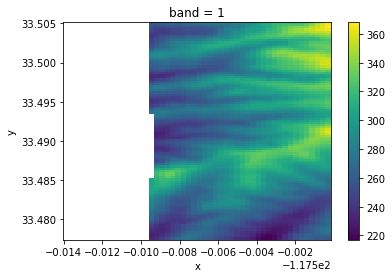

In [28]:
# ploting dataarray after removing missing values
da1.where(da1.data>da1.attrs["nodatavals"]).plot()

We can use `from_xarray` method from the contiguity classes like `Rook` and `Queen`, and also from `KNN`.

This uses a util function in raster file called `da2W`, which can also be called directly to build `W` object, similarly `da2WSP` for building `WSP` object

In [29]:
# Let's check the method first
help(Rook.from_xarray)

Help on method from_xarray in module libpysal.weights.contiguity:

from_xarray(da, layer=None, dims=None, sparse=False, **kwargs) method of builtins.type instance
    Construct a weights object from a xarray DataArray.
    
    Parameters
        ----------
    da : xarray.DataArray
        Input 2D or 3D DataArray with shape=(layer, height, width)
    layer : int/string/float
        Select the layer of 3D DataArray with multiple layers
    dims : dictionary
        Pass custom dimensions for coordinates and layers if they
        do not belong to default dimensions, which are (band/time, y/lat, x/lon)
        e.g. dims = {"lat": "latitude", "lon": "longitude", "layer": "year"}
    sparse : boolean
        type of weight object. Default is dense. For sparse, sparse = True
    **kwargs : keyword arguments
        optional arguments passed when sparse = False
    
    Returns
    -------
    w : libpysal.weights.W/libpysal.weights.WSP
        instance of spatial weights class W or WSP
 

In [30]:
# Creating weight of object from raster
w_rook = Rook.from_xarray(da1)

Lets check the index attributes added to the `W` object 

In [31]:
# coords contains the multi-indices of non-missing data values 
w_rook.index[:5]

MultiIndex([(1, 33.505, -117.50944444444444),
            (1, 33.505, -117.50916666666666),
            (1, 33.505, -117.50888888888889),
            (1, 33.505, -117.50861111111111),
            (1, 33.505, -117.50833333333333)],
           names=['band', 'y', 'x'])

Here we first convert the `DataArray` to `Series` and then use the indices from `index` attribute to remove missing values by subsetting the `Series` 

In [32]:
# Loading the raster data for further calculation
data1 = da1.to_series()[w_rook.index]
data1[:5]

band  y       x          
1     33.505  -117.509444    256
              -117.509167    261
              -117.508889    263
              -117.508611    263
              -117.508333    264
dtype: int16

In [33]:
# Quickly computing and loading a LISA
np.random.seed(12345)
lisa = Moran_Local(data1,w_rook)

We can use `w2da` function directly to convert the `W` object back to `DataArray`.

In [34]:
# Let's check the method first
help(raster.w2da)

Help on function w2da in module libpysal.weights.raster:

w2da(data, w, attrs={'nodatavals': (-1,)}, coords=None)
    Creates DataArray object from passed data aligned with W object.
    
    Parameters
    ---------
    data : array/list/pd.Series
        1d array-like data with dimensionality conforming to w
    w : libpysal.weights.W
        Spatial weights object aligned with passed data
    attrs : Dictionary
        Attributes stored in dict related to DataArray, e.g. da.attrs
    coords : Dictionary/xarray.core.coordinates.DataArrayCoordinates
        Coordinates corresponding to DataArray, e.g. da.coords
    
    Returns
    -------
    da : xarray.DataArray
        instance of xarray.DataArray



In [35]:
# Converting obtained data back to DataArray
moran_da1 = raster.w2da(lisa.p_sim, w_rook)
print(moran_da1)

<xarray.DataArray (band: 1, y: 100, x: 50)>
array([[[-1.   , -1.   , -1.   , ...,  0.055,  0.049,  0.111],
        [-1.   , -1.   , -1.   , ...,  0.049,  0.052,  0.091],
        [-1.   , -1.   , -1.   , ...,  0.068,  0.103,  0.168],
        ...,
        [-1.   , -1.   , -1.   , ...,  0.001,  0.001,  0.001],
        [-1.   , -1.   , -1.   , ...,  0.001,  0.001,  0.001],
        [-1.   , -1.   , -1.   , ...,  0.001,  0.001,  0.001]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 33.48 33.48 33.48 33.48 33.48 ... 33.5 33.5 33.5 33.51
  * x        (x) float64 -117.5 -117.5 -117.5 -117.5 ... -117.5 -117.5 -117.5
Attributes:
    nodatavals:  (-1,)


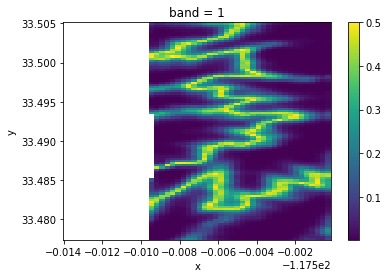

In [36]:
# Plotting the converted DataArray
moran_da1.where(moran_da1.data>0).plot()

This time we'll use this [netCDF dataset](https://www.unidata.ucar.edu/software/netcdf/examples) which we can access using `xarray.open_dataset`. 

In [37]:
# Lets load a netCDF Surface dataset
da_nc = xr.open_dataset('ECMWF_ERA-40_subset.nc')
print(da_nc)

<xarray.Dataset>
Dimensions:    (latitude: 73, longitude: 144, time: 62)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2002-07-01T12:00:00 ... 2002-07-31T18:00:00
Data variables:
    tcw        (time, latitude, longitude) float32 ...
    tcwv       (time, latitude, longitude) float32 ...
    lsp        (time, latitude, longitude) float32 ...
    cp         (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    blh        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    p10u       (time, latitude, longitude) float32 ...
    p10v       (time, latitude, longitude) float32 ...
    p2t        (time, latitude, longitude) float32 ...
    p2d        (time, latitude, longitude) float32 ...
    e          (time, latitude, longitude) float32 ...
  

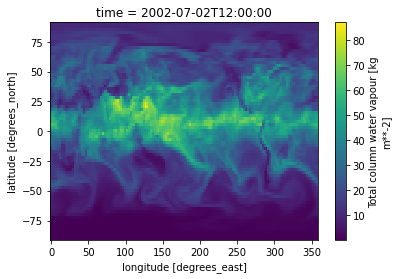

In [38]:
# We'll use water vapour data for further calculation, this will give us our desired DataArray
da2 = da_nc["tcwv"]
da2[2].plot()

We'll see another way we can use to build the weight object

In [39]:
# First lets check the docstrings of da2W
help(raster.da2W)

Help on function da2W in module libpysal.weights.raster:

da2W(da, criterion='queen', layer=None, dims=None, **kwargs)
    Create a W object from xarray.DataArray
    
    Parameters
    ----------
    da : xarray.DataArray
       Input 2D or 3D DataArray with shape=(layer, height, width)
    criterion : {"rook", "queen"}
       Type of contiguity. Default is queen.
    layer : int/string/float
       Select the layer of 3D DataArray with multiple layers
    dims : dictionary
       Pass custom dimensions for coordinates and layers if they
       do not belong to default dimensions, which are (band/time, y/lat, x/lon)
       e.g. dims = {"lat": "latitude", "lon": "longitude", "layer": "year"}
    **kwargs : keyword arguments
        Optional arguments for :class:`libpysal.weights.W`
    
    Returns
    -------
    w : libpysal.weights.W
       instance of spatial weights class W
    
    Examples
    --------
    >>> from libpysal.raster import da2W, testDataArray
    >>> da = testDat

In [40]:
# We'll use 3rd layer out of 73 layers for further calculation
layer = da2.time.values[2] # In this case we have time layer
w_queen = raster.da2W(da2, layer=layer)

In [41]:
# Loading the raster data using index attribute
data2 = da2.to_series()[w_queen.index]

In [42]:
# Converting obtained data back to DataArray
rast_da2 = raster.w2da(data2, w_queen)
print(rast_da2)

<xarray.DataArray (time: 1, latitude: 73, longitude: 144)>
array([[[ 0.2801094 ,  0.2801094 ,  0.2801094 , ...,  0.2801094 ,
          0.2801094 ,  0.2801094 ],
        [ 0.35708237,  0.35310364,  0.34646606, ...,  0.3716812 ,
          0.36637115,  0.36239243],
        [ 0.4393654 ,  0.42742157,  0.41680145, ...,  0.46855927,
          0.45794296,  0.44865417],
        ...,
        [10.079498  , 10.13789   , 10.194954  , ..., 10.254677  ,
         10.196281  , 10.13789   ],
        [ 9.618988  ,  9.629608  ,  9.640224  , ...,  9.695961  ,
          9.670746  ,  9.645531  ],
        [10.623611  , 10.623611  , 10.623611  , ..., 10.623611  ,
         10.623611  , 10.623611  ]]], dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 2002-07-02T12:00:00
  * latitude   (latitude) float64 -90.0 -87.5 -85.0 -82.5 ... 85.0 87.5 90.0
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
Attributes:
    nodatavals:  (-1,)


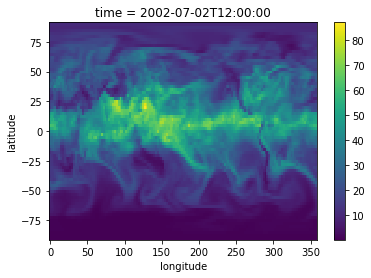

In [43]:
rast_da2.plot()

We will perform similar operations with different data.

In [44]:
# Lets load a different raster data with multiple bands 
da2 = xr.open_rasterio('HARV_RGB_Ortho.tif')
# Slicing the dataarray
da2 = da2[:, 0:100, 350:400]
da2.shape

(3, 100, 50)

In [45]:
# Again using da2WSP which creates queen contiguity as default
wsp_queen = raster.da2WSP(da2)

/data/GSoC/libpysal/libpysal/weights/raster.py:269: UserWarning: Multiple layers detected in da. Using first layer as default.
  warn('Multiple layers detected in da. Using first layer as default.')


 Now instead of using `lisa` will store back a `pandas.Series` containing random values to the `DataArray`.

In [46]:
ser = pd.Series(np.random.randint(0,9, len(wsp_queen.index)))

In [47]:
# Converting obtained data back to DataArray
ser_da1 = raster.wsp2da(ser, wsp_queen)
print(ser_da1)

<xarray.DataArray (band: 1, y: 100, x: 50)>
array([[[4, 8, 4, ..., 1, 4, 4],
        [4, 4, 1, ..., 4, 4, 3],
        [0, 0, 0, ..., 7, 1, 4],
        ...,
        [1, 5, 1, ..., 1, 2, 8],
        [0, 3, 0, ..., 0, 5, 4],
        [4, 5, 2, ..., 5, 7, 1]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.714e+06 4.714e+06 4.714e+06 ... 4.714e+06 4.714e+06
  * x        (x) float64 7.321e+05 7.321e+05 7.321e+05 ... 7.321e+05 7.321e+05


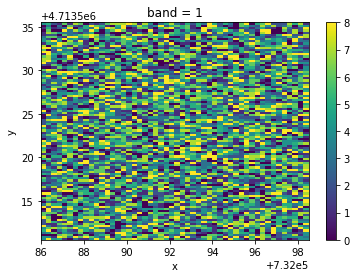

In [48]:
# Plotting the converted DataArray
ser_da1.plot()

To save some time we can use the metadata of the original `DataArray` to build the new `DataArray` much faster

In [49]:
# Converting obtained data back to DataArray
ser_da1 = raster.wsp2da(ser, wsp_queen, da2.attrs, da2[:1].coords)
print(ser_da1)

<xarray.DataArray (band: 1, y: 100, x: 50)>
array([[[4, 8, 4, ..., 1, 4, 4],
        [4, 4, 1, ..., 4, 4, 3],
        [0, 0, 0, ..., 7, 1, 4],
        ...,
        [1, 5, 1, ..., 1, 2, 8],
        [0, 3, 0, ..., 0, 5, 4],
        [4, 5, 2, ..., 5, 7, 1]]])
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 4.714e+06 4.714e+06 4.714e+06 ... 4.714e+06 4.714e+06
  * x        (x) float64 7.321e+05 7.321e+05 7.321e+05 ... 7.321e+05 7.321e+05
Attributes:
    transform:      (0.25, 0.0, 731998.5, 0.0, -0.25, 4713535.5)
    crs:            +init=epsg:32618
    res:            (0.25, 0.25)
    is_tiled:       0
    nodatavals:     (-1.7e+308, -1.7e+308, -1.7e+308)
    scales:         (1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area
